In [1]:
from __future__ import annotations

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import nshconfig_extra as CE

from jmp.lightning_module import Module

ckpt_path = CE.CachedPath(
    uri="hf://nimashoghi/mptrj-alex-omat24-jmp-s-1our3wgd/checkpoints/last/epoch1-step172332.ckpt"
)

# Load the model from the checkpoint
module = Module.load_from_checkpoint(ckpt_path.resolve()).cuda().eval()


Type checking the following modules: ('jmppeft',)
/opt/conda/envs/jmp-peft/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.3.1, which is newer than your current Lightning version: v2.2.1


Unrecognized arguments:  dict_keys(['ln', 'dropout', 'replace_scale_factors_with_ln', 'learnable_rbf', 'learnable_rbf_stds', 'unique_basis_per_layer', 'old_gaussian_implementation', 'edge_dropout'])


CRITICAL:root:Found the following scale factors: [('int_blocks.0.trip_interaction.scale_rbf', 'int_blocks.0.trip_interaction.scale_rbf'), ('int_blocks.0.trip_interaction.scale_cbf_sum', 'int_blocks.0.trip_interaction.scale_cbf_sum'), ('int_blocks.0.quad_interaction.scale_rbf', 'int_blocks.0.quad_interaction.scale_rbf'), ('int_blocks.0.quad_interaction.scale_cbf', 'int_blocks.0.quad_interaction.scale_cbf'), ('int_blocks.0.quad_interaction.scale_sbf_sum', 'int_blocks.0.quad_interaction.scale_sbf_sum'), ('int_blocks.0.atom_edge_interaction.scale_rbf', 'int_blocks.0.atom_edge_interaction.scale_rbf'), ('int_blocks.0.atom_edge_interaction.scale_cbf_sum', 'int_blocks.0.atom_edge_interaction.scale_cbf_sum'), ('int_blocks.0.edge_atom_interaction.scale_rbf', 'int_blocks.0.edge_atom_interaction.scale_rbf'), ('int_blocks.0.edge_atom_interaction.scale_cbf_sum', 'int_blocks.0.edge_atom_interaction.scale_cbf_sum'), ('int_blocks.0.atom_interaction.scale_rbf_sum', 'int_blocks.0.atom_interaction.scale_r

In [11]:
import datasets

dataset = datasets.load_dataset("nimashoghi/mptrj", split="train", streaming=True)
dataset = dataset.filter(lambda extxyz_id: extxyz_id == 0, input_columns=["extxyz_id"])
dataset_iter = iter(dataset)
dataset

IterableDataset({
    features: Unknown,
    n_shards: 8
})

In [12]:
import torch
from torch_geometric.data import Batch, Data


def new_batch():
    data_dict = next(dataset_iter)
    data = Data.from_dict(
        {
            "pos": torch.tensor(data_dict["positions"], dtype=torch.float),
            "atomic_numbers": (
                atomic_numbers := torch.tensor(data_dict["numbers"], dtype=torch.long)
            ),
            "tags": torch.full_like(atomic_numbers, 2, dtype=torch.long),
            "fixed": torch.zeros_like(atomic_numbers, dtype=torch.bool),
            # "natoms": data_dict["natoms"].long(),
            "natoms": torch.tensor(data_dict["num_atoms"], dtype=torch.long),
            # "cell": data_dict["cell"].view(1, 3, 3),
            "cell": torch.tensor(data_dict["cell"], dtype=torch.float).view(1, 3, 3),
            # "y": data_dict["corrected_total_energy"],
            "energy": torch.tensor(
                data_dict["corrected_total_energy"], dtype=torch.float
            ),
            # "force": data_dict["forces"],
            "force": torch.tensor(data_dict["forces"], dtype=torch.float),
            # "stress": data_dict["stress"].view(1, 3, 3),
            "stress": torch.tensor(data_dict["stress"], dtype=torch.float).view(
                1, 3, 3
            ),
            # "eform": data_dict["ef_per_atom_relaxed"],
            "eform": torch.tensor(data_dict["ef_per_atom_relaxed"], dtype=torch.float),
        }
    )
    batch = Batch.from_data_list([data])
    return batch


In [13]:
from lightning.fabric.utilities.apply_func import move_data_to_device
from tqdm import trange

num_embeddings = 10_000

torch.no_grad().__enter__()

embeddings = []
eforms = []

for i in trange(num_embeddings):
    while True:
        try:
            batch = new_batch()
            embedding = module.embeddings(batch)
            eform = batch.eform

            embedding = move_data_to_device(embedding, "cpu")
            eform = move_data_to_device(eform, "cpu")

            embeddings.append(embedding)
            eforms.append(eform)
            break
        except Exception as e:
            print(e)
            continue


  0%|          | 0/10000 [00:00<?, ?it/s]

 69%|██████▉   | 6913/10000 [03:37<01:33, 33.14it/s]

cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous


 82%|████████▏ | 8176/10000 [04:18<00:58, 31.18it/s]

cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous


100%|██████████| 10000/10000 [05:20<00:00, 31.23it/s]


In [14]:
import numpy as np

embeddings_avg = torch.stack(
    [embedding["energy"].mean(dim=0) for embedding in embeddings]
).numpy()
labels = torch.stack(eforms).numpy()

print(embeddings_avg.shape, labels.shape)

np.save("/mnt/shared/jmp-wbm-embeddings-omat/mptrj/embeddings_avg.npy", embeddings_avg)
np.save("/mnt/shared/jmp-wbm-embeddings-omat/mptrj/labels.npy", labels)


(10000, 256) (10000, 1)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

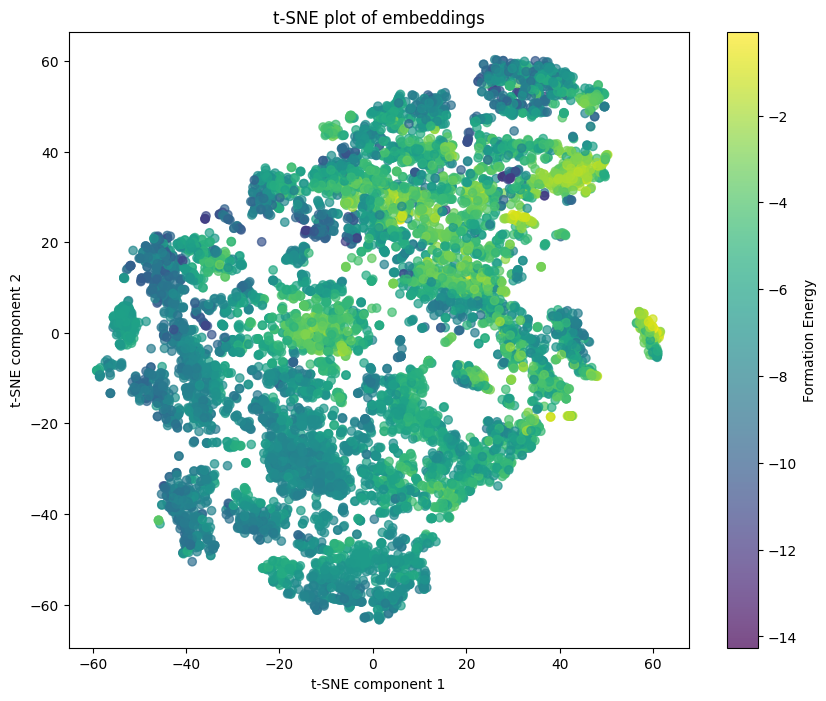

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
embeddings_tsne = tsne.fit_transform(embeddings_avg)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Formation Energy")
plt.title("t-SNE plot of embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()